# Credit Card Transaction Pattern Analysis

This notebook explores patterns in credit card transaction data to better understand how
transaction characteristics, such as transaction amount, vary across different outcomes.
The analysis uses SQL for aggregation and Python for data manipulation and visualization
to demonstrate a practical exploratory data analysis workflow.

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [27]:
df = pd.read_csv("data/transactions_sample.csv")

In [42]:
conn = sqlite3.connect("transactions.db")
df.to_sql("transactions", conn, if_exists="replace", index=False)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
1,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
2,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
3,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
4,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0


## Average Transaction Amount by Outcome

This analysis compares the average transaction amount across transaction outcomes
to assess whether transaction size differs meaningfully between groups.

In [10]:
query = """
SELECT Class, AVG(Amount) AS avg_amount
FROM transactions
GROUP BY Class;
"""

avg_amounts = pd.read_sql(query, conn)
avg_amounts

,Class,avg_amount
0,0,87.249921
1,1,164.233855


<Axes: title={'center': 'Average Transaction Amount by Fraud Class'}, xlabel='Class'>

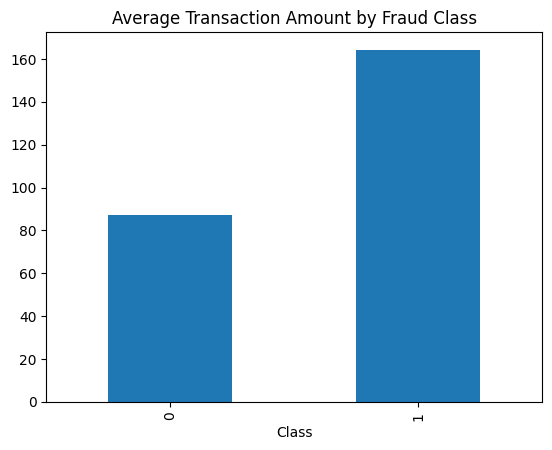

In [11]:
avg_amounts.plot(
    kind="bar",
    x="Class",
    y="avg_amount",
    legend=False,
    title="Average Transaction Amount by Fraud Class"
)

Transactions associated with flagged outcomes show a higher average amount,
suggesting transaction size may be a meaningful signal when analyzing transaction behavior.

## Outcome Rate by Transaction Amount

To further explore how transaction size relates to outcomes, transactions are grouped
into predefined amount buckets. This analysis calculates the outcome rate within each
bucket to identify transaction size ranges associated with higher relative risk.

In [12]:
query = """
SELECT
    CASE
        WHEN Amount < 50 THEN 'Under $50'
        WHEN Amount < 200 THEN '$50–$200'
        WHEN Amount < 500 THEN '$200–$500'
        ELSE '$500+'
    END AS amount_bucket,
    COUNT(*) AS total_transactions,
    SUM(Class) AS fraud_count,
    ROUND(100.0 * SUM(Class) / COUNT(*), 2) AS fraud_rate_pct
FROM transactions
GROUP BY amount_bucket
ORDER BY fraud_rate_pct DESC;
"""

fraud_by_amount = pd.read_sql(query, conn)
fraud_by_amount


,amount_bucket,total_transactions,fraud_count,fraud_rate_pct
0,$500+,1656,9,0.54
1,$200–$500,3479,9,0.26
2,$50–$200,11608,18,0.16
3,Under $50,33257,47,0.14


<Axes: title={'center': 'Fraud Rate by Transaction Amount'}, xlabel='amount_bucket'>

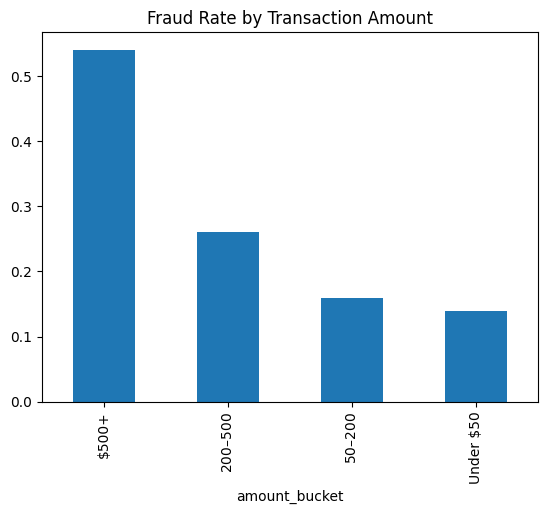

In [13]:
fraud_by_amount.plot(
    kind="bar",
    x="amount_bucket",
    y="fraud_rate_pct",
    legend=False,
    title="Fraud Rate by Transaction Amount"
)

Outcome rates increase with transaction amount, with the highest relative rate observed
in transactions over $500.

## High-Value Transaction Analysis ($500+)
This section focuses on transactions above $500 to better understand how outcomes differ
within the highest-value segment identified in earlier analysis.


In [45]:
high_value_df = df[df["Amount"] >= 500]

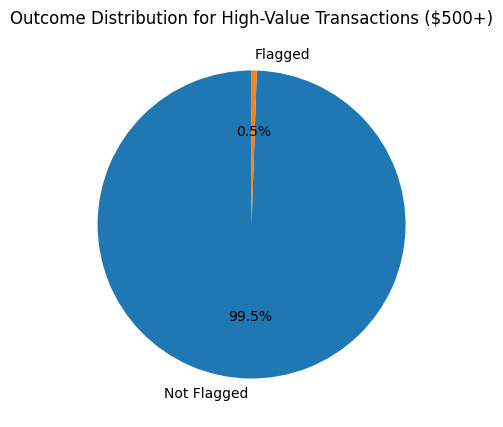

In [ ]:
counts = high_value_df["Class"].value_counts().sort_index()

plt.figure(figsize=(5, 5))
plt.pie(
    counts,
    labels=["Not Flagged", "Flagged"],
    autopct="%1.1f%%",
    startangle=90
)
plt.title("Outcome Distribution for High-Value Transactions ($500+)")
plt.show()


**Interpretation**
- Most high-value transactions are not flagged
- Flagged transactions represent a larger share of activity in this segment
- This suggests elevated relative risk among higher-value transactions

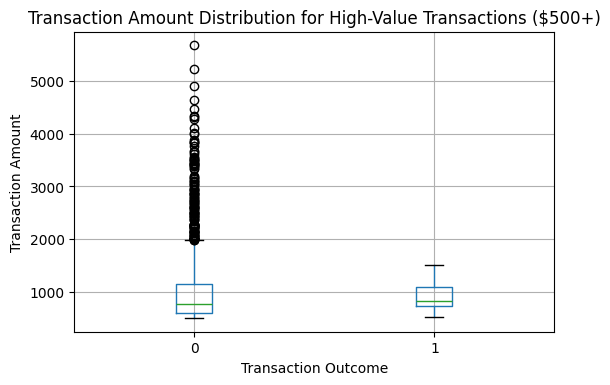

In [48]:
high_value_df.boxplot(
    column="Amount",
    by="Class",
    figsize=(6, 4)
)

plt.title("Transaction Amount Distribution for High-Value Transactions ($500+)")
plt.suptitle("")
plt.xlabel("Transaction Outcome")
plt.ylabel("Transaction Amount")
plt.show()


**Interpretation**
- Both groups span a wide range of transaction values within the $500+ segment
- Flagged transactions show greater variability and more extreme values
- Transaction amount alone does not fully distinguish outcomes in high-value transactions

**High-Value Segment Summary**

Within the $500+ bucket, outcome rates are elevated relative to lower transaction ranges.
However, distributional overlap indicates that transaction amount should be considered
alongside additional features when analyzing high-value activity.

## Key Takeaways
- Transaction amount shows clear variation across outcomes, with higher-value transactions associated with elevated relative risk
- Grouping transactions into amount buckets helps surface non-obvious patterns in large datasets
- SQL aggregation combined with Python visualization provides an efficient workflow for exploratory analysis
- High-value transactions ($500+) exhibit elevated outcome rates, but significant overlap
  remains between flagged and unflagged transaction amounts

## Conclusion

This analysis examined patterns in credit card transaction data to better understand how
transaction amount varies across different outcomes. Using SQL and Python, transactions
were compared across multiple size ranges to highlight meaningful differences.

This project demonstrates how SQL-based aggregation and exploratory data analysis can be
used to uncover actionable insights from transactional data and support further analysis,
monitoring, or decision-making.
